In [1]:
import os
import sys

import numpy as np
import copy

from glob import glob
import argparse

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# model_name = 'Flavor Tagging'
# MODEL = model_name.replace(' ', '_')
# MODELLSTM = "model_rnn_LSTM.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid"
# MODELGRU = "model_rnn_GRU.120_Dense.5010_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.0_KRl2.0_recAct.sigmoid"
# INTBIT = 8

# model_name = 'QuickDraw New Table Setup'
# MODEL = model_name.replace(' ', '_')
# MODELLSTM = "Quickdraw5ClassLSTMFinL.h5"
# MODELGRU = "Quickdraw5Class1GRU.h5"
# INTBIT = 10

model_name = 'Top Tagging'
MODEL = model_name.replace(' ', '_')
MODELLSTM = "model_toptag_lstm.h5"
MODELGRU = "model_toptag_gru.h5"
INTBIT = 8


# MODEL = "Quickdraw5Class1GRU.h5"
# MODEL = "Quickdraw5ClassLSTMFinL.h5"

# model_name = 'Flavor Tagging - LSTM'
# model_name = 'Flavor Tagging - GRU'
# model_name = 'QuickDraw'
# model_name = 'QuickDraw - GRU'
# model_name = 'QuickDraw - LSTM'
# model_name = 'Large GRU Model'

fld = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects/"

files_loc_lstm = f"{fld}/{MODELLSTM}/reports/*.txt"
files_loc_gru = f"{fld}/{MODELGRU}/reports/*NewBigTable.txt"

In [3]:
plot_loc = f'model_plots/{MODEL}'

if not os.path.exists(plot_loc):
    os.makedirs(plot_loc)

In [4]:
files = glob(files_loc_lstm) + glob(files_loc_gru)

In [5]:
files

['/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_toptag_lstm.h5/reports/model_28.4.AP_TRN.AP_WRAP_reuse_2048_Resource_NewTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_toptag_lstm.h5/reports/model_12.8.AP_TRN.AP_WRAP_reuse_64_Resource_NewTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_toptag_lstm.h5/reports/model_26.10.AP_TRN.AP_WRAP_reuse_256_Resource_NewTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_toptag_lstm.h5/reports/model_12.8.AP_TRN.AP_WRAP_reuse_2048_Resource_NewTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_toptag_lstm.h5/reports/model_12.6.AP_TRN.AP_WRAP_reuse_128_Resource_NewTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_toptag_lstm.h5/reports/model_26.8.AP_TRN.AP_WRAP_reuse_1_Latency_NewTable.txt',
 '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/hls/projects//model_toptag_lstm.h

In [6]:
base_dict = {
    'name':'',
    'file': '',
    'BRAM_18K': -1,
    'DSP48E': -1,
    'FF': -1,
    'LUT': -1,
    'URAM':-1,
    'LAT_min':-1,
    'LAT_max': -1,
    'ap_tot': -1,
    'ap_frac': -1,
    'ap_int': -1,
    'ap_quant': '',
    'ap_over': '',
    'strategy': '',
    'reuse': -1,
    'keras_auc': -1,
    'hls_auc': -1,
    'rel_auc': -1,
    'model': ''
}

In [7]:
dicts = []

lat_unit = 'us'

for ff in files:
    with open(ff, 'r') as hf:

        this_dict = copy.deepcopy(base_dict)
        this_dict['name'] = ff.split('/')[-1].replace('.txt', '')
        this_dict['file'] = ff
        
        this_dict['reuse'] = int(this_dict['name'].split('_reuse_')[-1].split('_')[0])
        this_dict['strategy'] = this_dict['name'].split('_reuse_')[-1].split('_')[1]

        modes = this_dict['name'].split('_reuse_')[0].replace('model_', '').split('.')

        this_dict['ap_tot'] = int(modes[0])
        this_dict['ap_int'] = int(modes[1])
        this_dict['ap_frac'] = this_dict['ap_tot'] - this_dict['ap_int']
        this_dict['ap_quant'] = modes[2]
        this_dict['ap_over'] = modes[3]
        this_dict['model'] = 'gru' if 'GRU' in ff or 'gru' in ff else 'lstm'

        for line in hf:
            if 'function' in line or 'none' in line or 'dataflow' in line:
                if '_' in line: continue
                
                sline = line.split()
                sline = [ sl.replace('|', '') for sl in sline ]

                this_dict['LAT_min'] = float(sline[3])
                this_dict['LAT_max'] = float(sline[6])
                
                # if sline[4] != sline[7]:
                #     print(sline[4], sline[7])
                #     break
                
                if 'ms' in sline[4]:
                    this_dict['LAT_min'] = this_dict['LAT_min']*1e3
                if 'ns' in sline[4]:
                    this_dict['LAT_min'] = this_dict['LAT_min']*1e-3
                    
                if 'ms' in sline[7]:
                    this_dict['LAT_max'] = this_dict['LAT_max']*1e3
                if 'ns' in sline[7]:
                    this_dict['LAT_max'] = this_dict['LAT_max']*1e-3
    
                # if 'none' in lat_unit:
                #     lat_unit = sline[4]
                # else:
                #     assert sline[4] == lat_unit

            if 'Total' in line and this_dict['FF'] == -1:
                sline = line.split()
                sline = [ sl.replace('|', '') for sl in sline ]
                
                this_dict['BRAM_18K']  = int( sline[2] )
                this_dict['DSP48E']    = int( sline[3] )
                this_dict['FF']        = int( sline[4] )
                this_dict['LUT']       = int( sline[5] )
                this_dict['URAM']      = int( sline[6] )
            
            if 'KERAS_AUC' in line:
                sline = line.split()
                this_dict['keras_auc'] = float(sline[1])

            if 'HLS_AUC' in line:
                sline = line.split()
                this_dict['hls_auc'] = float(sline[1])

        # this_dict['rel_auc'] = abs( this_dict['keras_auc'] - this_dict['hls_auc'] ) / this_dict['keras_auc']
        this_dict['rel_auc'] = abs( this_dict['hls_auc'] ) / this_dict['keras_auc']
        dicts.append(this_dict)

In [8]:
tot_dict = copy.deepcopy(base_dict)

for kk in tot_dict:
    tot_dict[kk] = [ dd[kk] for dd in dicts]

In [9]:
tot_dict

{'name': ['model_28.4.AP_TRN.AP_WRAP_reuse_2048_Resource_NewTable',
  'model_12.8.AP_TRN.AP_WRAP_reuse_64_Resource_NewTable',
  'model_26.10.AP_TRN.AP_WRAP_reuse_256_Resource_NewTable',
  'model_12.8.AP_TRN.AP_WRAP_reuse_2048_Resource_NewTable',
  'model_12.6.AP_TRN.AP_WRAP_reuse_128_Resource_NewTable',
  'model_26.8.AP_TRN.AP_WRAP_reuse_1_Latency_NewTable',
  'model_22.12.AP_TRN.AP_WRAP_reuse_256_Resource_NewTable',
  'model_20.12.AP_TRN.AP_WRAP_reuse_1024_Resource_NewTable',
  'model_18.8.AP_TRN.AP_WRAP_reuse_1_Latency_NewTable',
  'model_8.4.AP_TRN.AP_WRAP_reuse_256_Resource_NewTable',
  'model_22.8.AP_TRN.AP_WRAP_reuse_32_Resource_NewTable',
  'model_20.6.AP_TRN.AP_WRAP_reuse_512_Resource_NewTable',
  'model_16.4.AP_TRN.AP_WRAP_reuse_128_Resource_NewTable',
  'model_14.8.AP_TRN.AP_WRAP_reuse_64_Resource_NewTable',
  'model_22.4.AP_TRN.AP_WRAP_reuse_1024_Resource_NewTable',
  'model_26.8.AP_TRN.AP_WRAP_reuse_32_Resource_NewTable',
  'model_22.10.AP_TRN.AP_WRAP_reuse_64_Resource_NewT

In [10]:
import pandas as pd

In [11]:
pd_dict = pd.DataFrame.from_dict(tot_dict)

In [12]:
pd_dict[pd_dict.model=='lstm'].reuse == 1

0      False
1      False
2      False
3      False
4      False
       ...  
427    False
428    False
429    False
430    False
431    False
Name: reuse, Length: 432, dtype: bool

In [13]:
def get_plot(st, reu, apint, var, model, max_x = 18):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) ].ap_frac.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.model == model) ][var].to_numpy()
    sort_i = xi.argsort()
    x = np.array(xi[sort_i], dtype=int)
    y = yi[sort_i]
    y = y[x < max_x+1]
    x = x[x < max_x+1]
    return [x,y]

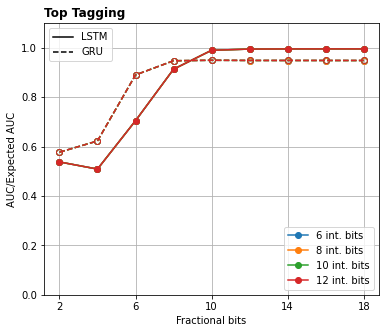

In [14]:
strat = 'Resource'

vars = ['rel_auc']
var_labs = [ r'AUC/Expected AUC']

for reuse in [1024]:
    
    for ivv,vv in enumerate(vars):
        

        fig, ax = plt.subplots(1,1,figsize=(6,5))

        myplot = get_plot(strat, reuse, 6, vv, model='lstm')
        ax.plot( myplot[0],myplot[1], 'o-', color='C0', label='6 int. bits' )
        
        myplot = get_plot(strat, reuse, 6, vv, model='gru')
        ax.plot( myplot[0],myplot[1], 'o--', color='C0', fillstyle='none' )

        myplot = get_plot(strat, reuse, 8, vv, model='lstm')
        ax.plot( myplot[0],myplot[1], 'o-', color='C1', label='8 int. bits' )
        ax.set_xticks(np.arange(min(myplot[0]), max(myplot[0])+1, 4.0))
        
        myplot = get_plot(strat, reuse, 8, vv, model='gru')
        ax.plot( myplot[0],myplot[1], 'o--', color='C1', fillstyle='none' )

        myplot = get_plot(strat, reuse, 10, vv, model='lstm')
        ax.plot( myplot[0],myplot[1], 'o-', color='C2', label='10 int. bits' )

        myplot = get_plot(strat, reuse, 10, vv, model='gru')
        ax.plot( myplot[0],myplot[1], 'o--', color='C2', fillstyle='none' )
        
        myplot = get_plot(strat, reuse, 12, vv, model='lstm')
        plt.plot( myplot[0],myplot[1], 'o-', color='C3', label='12 int. bits' )
        
        myplot = get_plot(strat, reuse, 12, vv, model='gru')
        plt.plot( myplot[0],myplot[1], 'o--', color='C3', fillstyle='none' )
        

        # plt.legend(title=f'Strat.: {strat},\n Reuse: {reuse}', frameon=False)
        ax.legend(frameon=True, loc='lower right')
        # plt.legend(frameon=False)
        ax.set_xlabel('Fractional bits')
        if 'LAT' in vv:
            ax.set_ylabel(var_labs[ivv]+f' ({lat_unit})')
        else:
            ax.set_ylabel(var_labs[ivv])
            

        lines = [mpl.lines.Line2D([0], [0], ls='-', color='black', ),
                     mpl.lines.Line2D([0], [0], ls='--', color='black')]
        
        leg = mpl.legend.Legend(ax, lines, labels=['LSTM', 'GRU'],
            loc='upper left', frameon=True)
        ax.add_artist(leg)

        plt.ylim(0,1.1)
        plt.title(model_name, loc='left', fontweight="bold")
        plt.grid()
        plt.savefig(f"{plot_loc}/{vv}_{reuse}.pdf")
        plt.show()

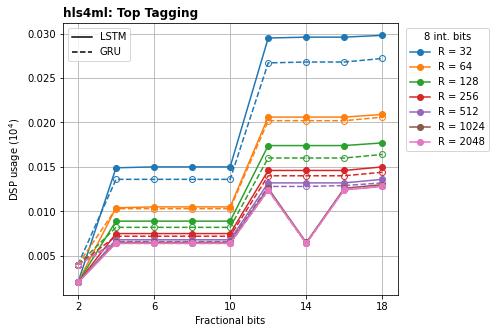

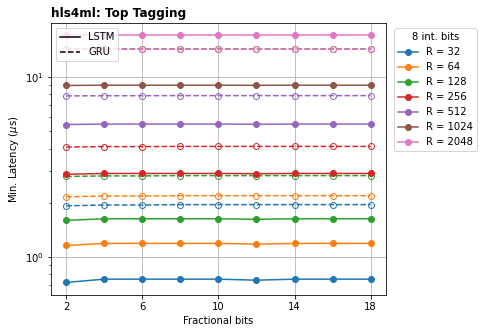

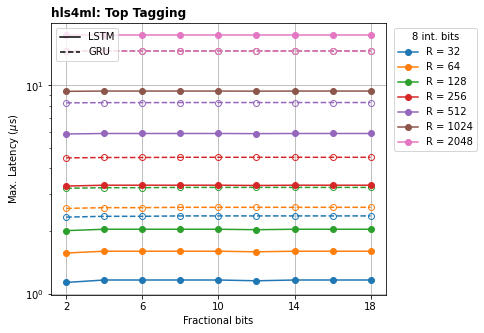

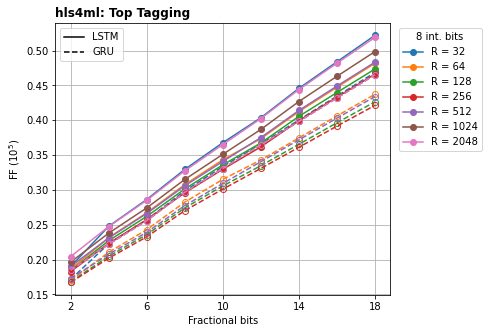

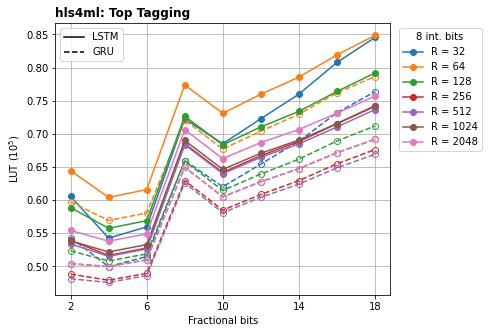

In [25]:
strat = 'Resource'

vars = ['DSP48E', f'LAT_min', f'LAT_max', 'FF', 'LUT']
var_labs = ['DSP usage', f'Min. Latency', f'Max. Latency', 'FF', 'LUT']
facts = [4, 1, 1, 5, 5]
    
for ivv,vv in enumerate(vars):

    fig, ax = plt.subplots(1,1,figsize=(6,5))
    # plt.xlim(9,31)

    # for ire,reuse in enumerate([50, 100, 200, 500, 1000, 2000]):
    # for ire,reuse in enumerate([50, 100, 200, 1000]):
    for ire,reuse in enumerate([32, 64, 128, 256, 512, 1024, 2048]):
        
        myplot = get_plot(strat, reuse, INTBIT, vv, 'lstm')
        ax.plot( myplot[0],myplot[1]/(10**facts[ivv]), 'o-', color=f'C{ire}', label='R = ' + f'{reuse}' )
        
        myplot = get_plot(strat, reuse, INTBIT, vv, 'gru')
        ax.plot( myplot[0],myplot[1]/(10**facts[ivv]), 'o--', color=f'C{ire}', fillstyle='none' )
        
        ax.set_xticks(np.arange(min(myplot[0]), max(myplot[0])+1, 4.0))


    ax.legend(title=f'{INTBIT} int. bits', frameon=True,
              bbox_to_anchor=(1.01, 1.))
    # plt.legend(frameon=False)
    ax.set_xlabel('Fractional bits')
    if 'LAT' in vv:
        ax.set_yscale('log')
        unit = lat_unit.replace('u', '$\\mu$')
        ax.set_ylabel(var_labs[ivv] +f' ({unit})')
    else:
        ax.set_ylabel(var_labs[ivv] +f' ($10^{str(facts[ivv])} $)')
        
    lines = [mpl.lines.Line2D([0], [0], ls='-', color='black', ),
                     mpl.lines.Line2D([0], [0], ls='--', color='black')]
        
    leg = mpl.legend.Legend(ax, lines, labels=['LSTM', 'GRU'],
            loc='upper left', frameon=True)
    ax.add_artist(leg)

    plt.title('hls4ml: ' +model_name, loc='left', fontweight="bold")
    plt.grid()
    plt.savefig(f"{plot_loc}/{vv}_reuseScan.pdf", bbox_inches='tight')
    plt.show()